# Team Momento Mori
In this project, we plan to analyze CDC Data to predict the likelihood of an individual dying from a natural cause or an unnatural cause.

## 1) Installing Dependencies

In [27]:
# import the the essentials
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RepeatedStratifiedKFold, StratifiedKFold
#metrics
from sklearn.metrics import f1_score, recall_score, confusion_matrix, classification_report, roc_curve,  ConfusionMatrixDisplay

from sklearn.preprocessing import StandardScaler

#models
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import xgboost

import warnings
warnings.filterwarnings('ignore')

#user-defined modules
import data_preprocessing
import data_collection

## 2) Loading the Data set

The data are obtained from the National Vital Statistics System of the United States Center for Disease Control. These data are from the Mortality Multiple Cause-of-Death for years ranging from 2005 to 2015.  
1. Each csv file corresponds to a year of recorded deaths.
2. The raw data consist of 2,718,198 instances with 77 columns.  These columns are features which include codes for causes of death and as well as demographic information of the deceased, such as
    - age of death
    - sex of decedent
    - education level of decedent
    - marital status of decedent
    - location of death relative to residence of decedent
    - race
3. The features for cause(s) of death are coded here -- the correspondence can be found at https://www.cdc.gov/nchs/data/dvs/Multiple_Cause_Record_Layout_2015.pdf.

In our project, there are 10 different data sets corresponding to every year between 2005 and 2015. 

In order to collect data sets, please run the following and enter the sequence of the years that you wish to consider one by one. After, the final year that you would like to consider you can enter a blank input to end the sequence.

For example: Suppose we want to install datasets from the years 2013 and 2015. After running the next code, we can type 2015 first and then press enter. Next, we will be asked again to enter a year, we can type 2013 and press enter again. Finally, we will be asked once more to enter a year input. We can leave the input space blank and enter press to finalize the sequence. In return, the data sets that belong to years 2013 and 2015 will be installed and collected as one single dataframe.  

**Please note** that, each of the data sets from 2005 to 2015 requires roughly about 1.6 GB memory. Which means that installing many years will require a large amoung of memory and calculations will be slower. For both training and computation purposes, it sufficies to install only one year. 

In [50]:
df, causes = data_collection.DataCollection().dataframe

Please enter the sequence of years (between 2005 and 2015) e.g. 2015 . Enter blank to end the sequence or enter all to get all data sets:
Please enter the sequence of years (between 2005 and 2015), enter blank to end the sequence or enter all to get all data sets:2015
Current set of years : {'2015'}
Please enter the sequence of years (between 2005 and 2015), enter blank to end the sequence or enter all to get all data sets:
You entered blank, sequence is ended. The data from the following years will be loaded into memory:
{'2015'}


In [51]:
df.head()

,resident_status,education_1989_revision,education_2003_revision,education_reporting_flag,month_of_death,sex,detail_age_type,detail_age,age_substitution_flag,age_recode_52,...,record_condition_18,record_condition_19,record_condition_20,race,bridged_race_flag,race_imputation_flag,race_recode_3,race_recode_5,hispanic_origin,hispanic_originrace_recode
0,1,NaN,3.0,1,1,M,1,84,NaN,42,...,NaN,NaN,NaN,1,NaN,NaN,1,1,100,6
1,1,NaN,6.0,1,1,M,1,70,NaN,40,...,NaN,NaN,NaN,1,NaN,NaN,1,1,100,6
2,1,NaN,3.0,1,1,F,1,91,NaN,44,...,NaN,NaN,NaN,1,NaN,NaN,1,1,100,6
3,1,NaN,3.0,1,1,F,1,40,NaN,34,...,NaN,NaN,NaN,3,NaN,NaN,2,3,100,8
4,1,NaN,5.0,1,1,F,1,89,NaN,43,...,NaN,NaN,NaN,1,NaN,NaN,1,1,100,6


In [ ]:
df.sample(5)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2718198 entries, 0 to 2718197
Data columns (total 78 columns):
 #   Column                                                  Dtype  
---  ------                                                  -----  
 0   resident_status                                         int64  
 1   education_1989_revision                                 float64
 2   education_2003_revision                                 float64
 3   education_reporting_flag                                int64  
 4   month_of_death                                          int64  
 5   sex                                                     object 
 6   detail_age_type                                         int64  
 7   detail_age                                              int64  
 8   age_substitution_flag                                   float64
 9   age_recode_52                                           int64  
 10  age_recode_27                                         

### Natural/Unnatural encoding
    For this project we look at '113_cause_recode' as target column.

We now encode the deaths which we rule unnatural.  By an **unnatural death**, we mean a death which is caused by one of the following causes:
1. Accident: 
    1. Unintentional injuries
    2. Transportation
    3. Motor vehicle, land/water/air/space
    4. Nontransport accidents
    5. Falls
    6. Accidental discharge of firearms
    7. Accidental drowning
    8. Accidental exposure to smoke, fire, flames
    9. Accidental poisoning
2. Homicide:
    1. Assault, not by the below causes
    2. Assault with firearms
    3. Assault with unspecified means
3. Suicide:
    1. Suicide by means other than the causes below
    2. Suicide by discharge of firearm
    3. Suidice by unspecified means
4. Execution
5. Undetermined intent
    1. U.I. except those listed below
    2. Discharge of firearms, undetermined intent
    3. Other
6. Operations of war
7. Complications from medical and surgical care

These correspond to cause of death codes 112-135 in the feature `113_cause_recode`.

In [6]:
display(causes)

112    Accidents (unintentional injuries) (V01-X59,Y8...
113                    Transport accidents (V01-V99,Y85)
114    Motor vehicle accidents (V02-V04,V09.0,V09.2,V...
115    Other land transport accidents (V01,V05-V06,V0...
116    Water, air and space, and other and unspecifie...
117                 Nontransport accidents (W00-X59,Y86)
118                                      Falls (W00-W19)
119           Accidental discharge of firearms (W32-W34)
120         Accidental drowning and submersion (W65-W74)
121    Accidental exposure to smoke, fire and flames ...
122    Accidental poisoning and exposure to noxious s...
123    Other and unspecified nontransport accidents a...
124    Intentional self-harm (suicide) (*U03,X60-X84,...
125    Intentional self-harm (suicide) by discharge o...
126    Intentional self-harm (suicide) by other and u...
127         Assault (homicide) (*U01-*U02,X85-Y09,Y87.1)
128    Assault (homicide) by discharge of firearms (*...
129    Assault (homicide) by ot

There are no missing data in the target column:

In [52]:
df['113_cause_recode'].isna().sum()

0

In [53]:
# One hot encoding for classification '113_cause_recode'
df['unnatural']=1
df.loc[df['113_cause_recode']<112,'unnatural']=0

In [54]:
df['unnatural'].value_counts(normalize=True)

0    0.919834
1    0.080166
Name: unnatural, dtype: float64

<IPython.core.display.Javascript object>


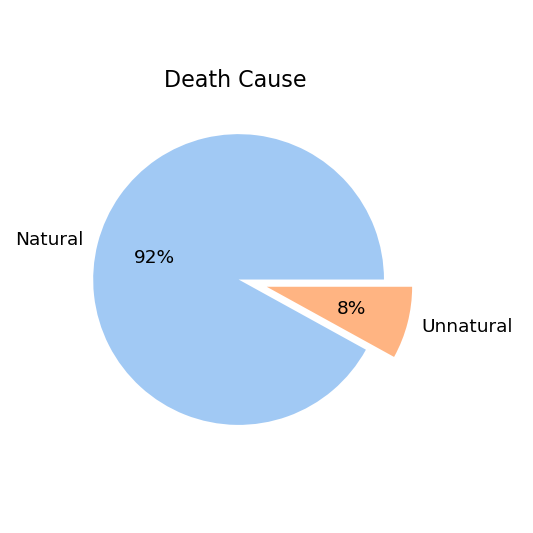

In [70]:
%matplotlib notebook
fig, ax = plt.subplots(1,1,figsize = (4,4))

colors = sns.color_palette('pastel')[0:5]
labels = ["Natural", "Unnatural"]
explode = [ 0, .2]

#create pie chart
ax.pie(df['unnatural'].value_counts(), 
       labels = labels,
       colors = colors, 
       explode = explode, 
       autopct='%.0f%%')
ax.set_title('Death Cause ');
fig.tight_layout()

As it can be seen above, about 92% of the deaths are natural, so we have classification problem with an inbalanced dataset.

Next we dive deeper into features and investigate features for our prediction model.

## 3) Exploratory Data Analysis
Below we conduct exploratory data analysis in order to select features on which to train our model.  

In [56]:
#Use this for eda
df_eda = df[df['detail_age']!=999] 

### 3.1) `detail_age`
The feature `detail_age` records the age of death of the decedent.  We construct two sets of plots:
1. Two enhanced boxplots to plot the feature `detail_age` one for natural and another for unnatural deaths.  
2. Two histograms of `detail_age`, one for natural and another for unnatural deaths.  

<IPython.core.display.Javascript object>


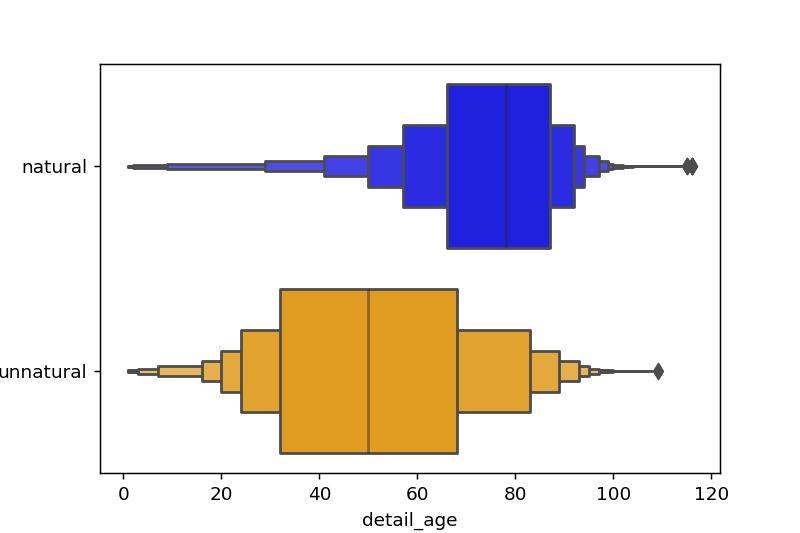

In [57]:
from matplotlib.patches import Patch
fig, ax = plt.subplots(1,1,figsize = (6,4))

sns.boxenplot(x="detail_age", y="unnatural", 
            data=df_eda, orient="h",
            palette={1:"orange", 0:"blue"}, ax=ax,
             )

color_patches = [
    Patch(facecolor="red", label="unnatural = 0"),
    Patch(facecolor="blue", label="natural = 1")]
    
ax.set_ylabel('')
ax.set_yticklabels(['natural','unnatural']);

Based on these two boxplots, we can make the following conclusions:
1. Natural deaths are skewed left yet still have outliers to the right.
2. Unnatural deaths are more symmetrically distributed, but still have some outliers to the right.
3. The median age of unnatural death is significantly smaller than the median age of natural death.

We record some of the summary statistics of these two distributions below:

In [58]:
age_group = df_eda.groupby('unnatural')

def quantile(x,q):
    return np.quantile(x,q)
age_group_agg = age_group.agg({"detail_age":[("mean", lambda x: np.round(np.mean(x), 1)),
                             ("min",np.min), 
                             ("q_25",lambda x: quantile(x,0.25)),
                             ('median',np.median), 
                             ("q_75",lambda x: quantile(x,0.75)),
                             ('max',np.max), 
                             ("IQR", lambda x: quantile(x,0.75) - quantile(x, 0.25)),
                                            ('sd',lambda x: np.round(np.std(x), 1))]})['detail_age']
print('Summary of the feature detail_age, by unnatural:')
print('=========================================================')
print(age_group_agg)

Summary of the feature detail_age, by unnatural:
           mean  min  q_25  median  q_75  max   IQR    sd
unnatural                                                
0          75.2    1  66.0    78.0  87.0  116  21.0  16.2
1          51.3    1  32.0    50.0  68.0  109  36.0  23.1


<IPython.core.display.Javascript object>


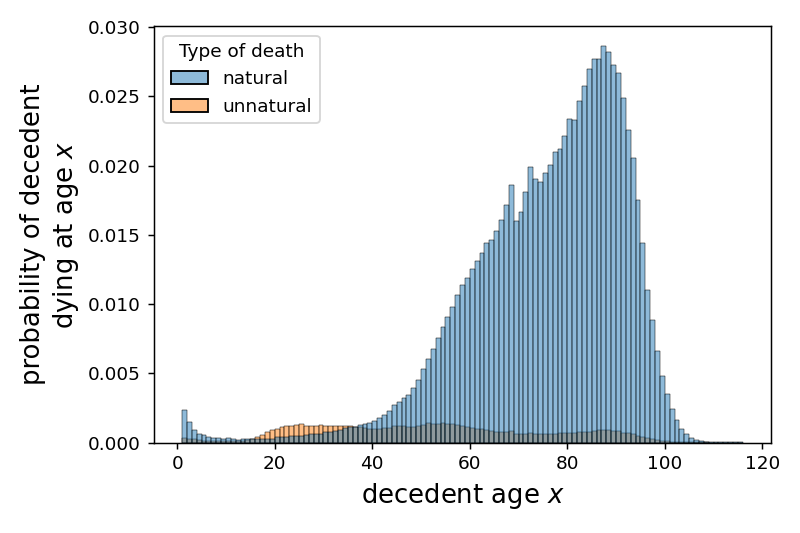

In [59]:
fig, ax = plt.subplots(1,1,figsize = (6,4))

bins = sorted(df_eda['detail_age'].unique())

sns.histplot(data = df_eda,
            x = 'detail_age',
            hue = 'unnatural',
            stat='probability', 
            bins = bins);

ax.set_xlabel('decedent age $x$', fontsize = 14)
ax.set_ylabel('probability of decedent\ndying at age $x$', fontsize = 14)
legend = ax.get_legend()
handles = legend.legendHandles
legend.remove()
ax.legend(handles, ['natural','unnatural'], title='Type of death')

fig.tight_layout()

<IPython.core.display.Javascript object>


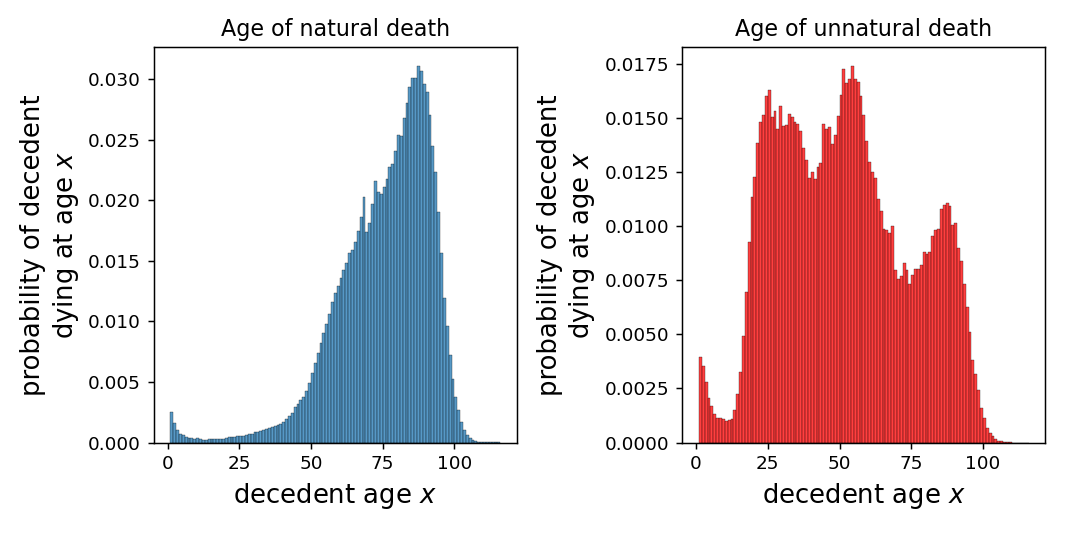

In [60]:
fig, ax = plt.subplots(1,2,figsize = (8,4))

bins = sorted(df_eda['detail_age'].unique())

sns.histplot(data = df_eda[df_eda['unnatural'] == 0],
            x = 'detail_age',
#             hue = 'unnatural',
            stat='probability', 
            bins = bins,
            ax = ax[0]);
ax[0].set_xlabel('decedent age $x$', fontsize = 14)
ax[0].set_ylabel('probability of decedent\ndying at age $x$', fontsize = 14)
ax[0].set_title('Age of natural death')

sns.histplot(data = df_eda[df_eda['unnatural'] == 1],
            x = 'detail_age',
             color = 'red',
            stat='probability', 
            bins = bins,
            ax = ax[1]);
ax[1].set_xlabel('decedent age $x$', fontsize = 14)
ax[1].set_ylabel('probability of decedent\ndying at age $x$', fontsize = 14)
ax[1].set_title('Age of unnatural death')
fig.tight_layout()

### 3.2) `sex`
We also plot histograms for age of both natural and unnatural deaths colored by the variable `sex`.  The left-hand plot is the plot of the age of death for natural deaths, and the right-hand plot is for unnatural deaths.

<IPython.core.display.Javascript object>


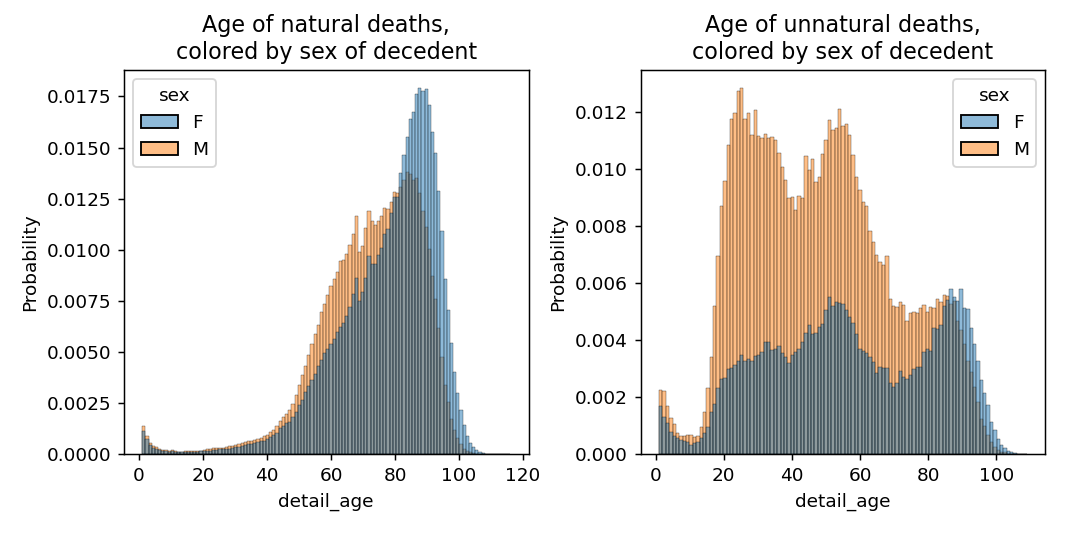

In [61]:
fig, ax = plt.subplots(1, 2, figsize = (8,4))

#first plot is of the age distribution of natural deaths
sns.histplot(data = df_eda[df_eda.unnatural == 0],
            x = 'detail_age',
            ax = ax[0],
            hue = 'sex',
             stat = 'probability',
             hue_order = ['F','M'],
            bins = int(df_eda.loc[df_eda.unnatural == 0,'detail_age'].max())
            )
            
ax[0].set_title('Age of natural deaths,\ncolored by sex of decedent')
# ax[0].set_xticks(range(0,115,10))

#second plot is of the age distribution of unnatural deaths
sns.histplot(data = df_eda[df_eda.unnatural == 1],
            x = 'detail_age',
            ax = ax[1],
            hue = 'sex',
             stat = 'probability',
             hue_order = ["F","M"],
            bins = int(df_eda.loc[df_eda.unnatural == 1,'detail_age'].max())
            )
ax[1].set_title('Age of unnatural deaths,\ncolored by sex of decedent')
# ax[1].set_xticks(range(0,115,10))
fig.tight_layout()

We may draw the following conclusions:
1. Up until roughly age 80, males have a higher frequency of natural death than females.
2. Up until roughly age 90, males have a higher frequency of unnatural death than females.

### 3.3) `marital_status`
Below we plot histograms of the categorical variable `marital_status`, one for natural and the other for unnatural deaths.

<IPython.core.display.Javascript object>


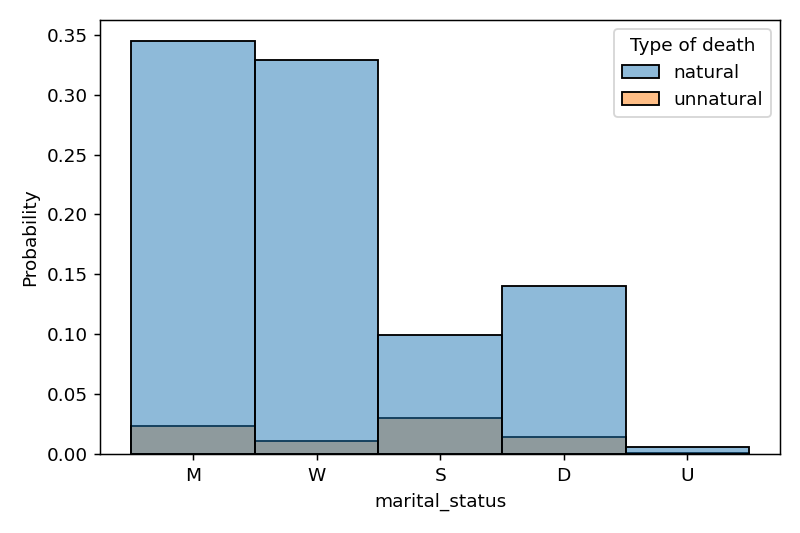

In [62]:
fig, ax = plt.subplots(1,1,figsize = (6,4))

sns.histplot(data = df_eda,
            x = 'marital_status',
            hue = 'unnatural',
             hue_order = [0,1],
            stat = 'probability',
             ax = ax,
            );
legend = ax.get_legend()
handles = legend.legendHandles
legend.remove()
ax.legend(handles, ['natural','unnatural'], title='Type of death')
fig.tight_layout()

**WRITE SOME COMMENTS HERE ON THE ABOVE HISTOGRAM**

Now we plot the histograms based on the following random variables: let $X$ be the random variable indicating natural death or unnatural death, $A$ be the random variable denoting the age of death, and $Y$ be the random variable indicating marital status.  This is to see, after conditioning for type of death we desire to see what effect, if any, marital status has on the age of death.  Formally, for $a > 0$, we consider

1. $\mathbb{P}(A = a | X = 1, Y = s)$ for $s\in \{Married, Single, Widowed, Divorced, Unknown\}$,
2. $\mathbb{P}(A = a | X = 0, Y = s)$ for $s\in \{Married, Single, Widowed, Divorced, Unknown\}$,

where $X = 1$ if the death is unnatural and $X = 0$ if the death is natural.  

<IPython.core.display.Javascript object>


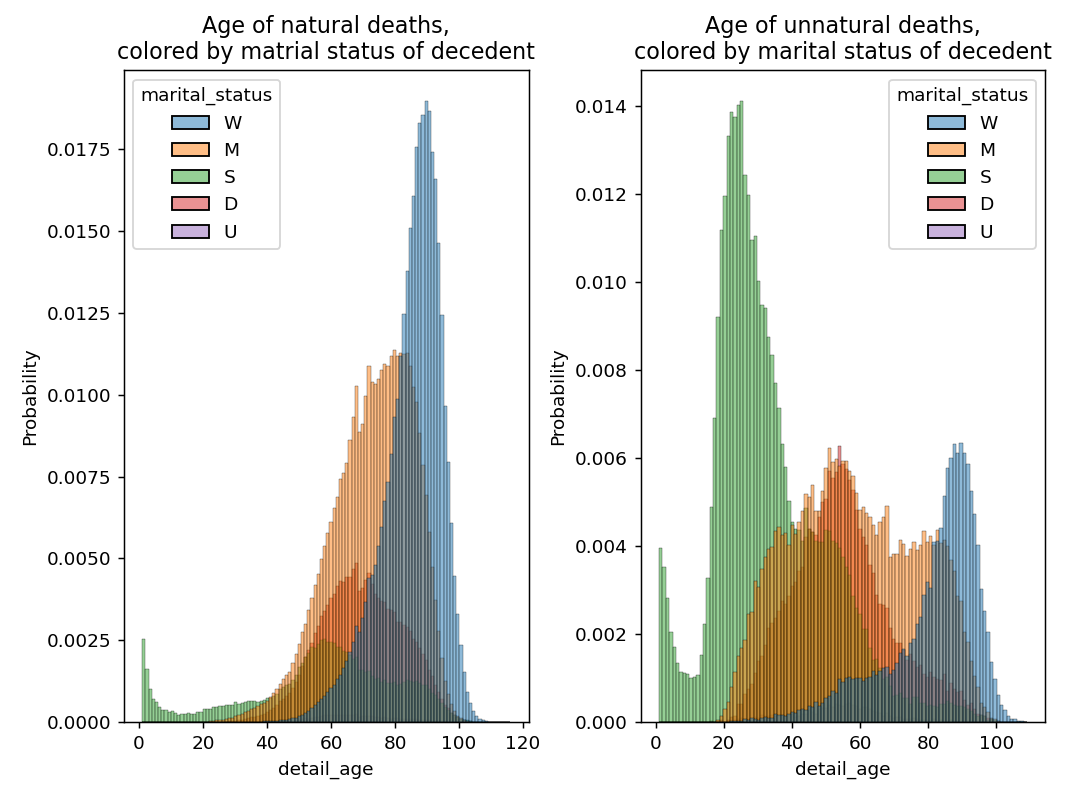

In [63]:
fig, ax = plt.subplots(1, 2, figsize = (8,6))

#first plot is of the age distribution of natural deaths
sns.histplot(data = df_eda[(df_eda.unnatural == 0)],
            x = 'detail_age',
            ax = ax[0],
            hue = 'marital_status',
             hue_order = ['W','M','S','D','U'],
             stat = 'probability',
            bins = int(df_eda.loc[df_eda.unnatural == 0,'detail_age'].max())
            )
ax[0].set_title('Age of natural deaths,\ncolored by matrial status of decedent')

#second plot is of the age distribution of unnatural deaths
sns.histplot(data = df_eda[(df_eda.unnatural == 1)],
            x = 'detail_age',
            ax = ax[1],
            hue = 'marital_status',
             hue_order = ['W','M','S','D','U'],
             stat = 'probability',
            bins = int(df_eda.loc[df_eda.unnatural == 1,'detail_age'].max()))
ax[1].set_title('Age of unnatural deaths,\ncolored by marital status of decedent')

fig.tight_layout()

We draw the following conclusions:
1. Marital status has a significant effect on age of unnatural death, particularly for single (S) decedents.  
2. We see what is expected for the distribution of natural death, namely, that it is more likely that as one is older that one is married or widowed.

### 3.4) `education`

In [64]:
continuous_variables = ['education_2003_revision',
                     'detail_age']

categorical_variables = ['marital_status','sex']

features_of_interest = continuous_variables + categorical_variables

pre_processor = data_preprocessing.DataPreprocesor(categorical_variables,
                                                   continuous_variables,
                                                   target_column='unnatural')

df_eda = pre_processor.education_convertor(df_eda)

<IPython.core.display.Javascript object>


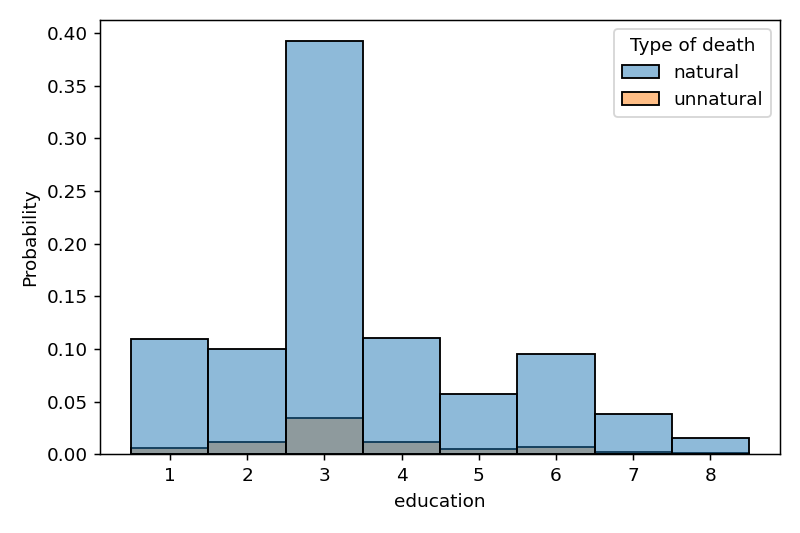

In [65]:
fig, ax = plt.subplots(1,1,figsize = (6,4))

sns.histplot(data = df_eda,
            x = 'education',
            hue = 'unnatural',
            stat = 'probability',
            bins = np.arange(1,10)-0.5
            );
legend = ax.get_legend()
handles = legend.legendHandles
legend.remove()
ax.legend(handles, ['natural','unnatural'], title='Type of death')
fig.tight_layout()

In [23]:
del df_eda

### EDA Conclusions
Based on our EDA, we will use the following features in our model: `detail_age`, `sex`, `marital_status`, `education` **EDUCATION IS NOT ADDED IN THE EDA BECAUSE IT NEEDS CLEANING**

## 4) Data Cleaning

We begin cleaning the data by splitting the features obtained from the above exploratory data analysis into categorical features, which will require one-hot encoding, and continuous features, which will require median imputation, removal of missing values in the case of `education` and scaling in the case of `detail_age`.

In [66]:
continuous_variables = ['education_2003_revision',
                     'detail_age']

categorical_variables = ['marital_status','sex']

features_of_interest = continuous_variables + categorical_variables

### 4.1) Inspection of missing data points

In [68]:
# Count Nan's: 
for column in df[features_of_interest]:
    print(f'\t {column} has: { df[column].isna().sum() } many missing points and { len(df[column].unique()) } many different unique values \n')

	 education_2003_revision has: 73043 many missing points and 10 many different unique values 

	 detail_age has: 0 many missing points and 117 many different unique values 

	 marital_status has: 0 many missing points and 5 many different unique values 

	 sex has: 0 many missing points and 2 many different unique values 



We built a simple process for coding missing education data from the data documentation.  The process is described below.
1. In the feature `education_2003_revision` some of the instances use a 1989 code, and these are the codes which are `nan` values.  Unstated education levels, which are truly missing, are encoded with a `99`.  
2. An instance is missing a recorded value for `education_2003_revision` if its `education_2003_revision` has the value 9.

To clean the education data, we create a new feature, named `education` which returns the 2003 education revision and updates the instances which use the 1989 revision.  Values of 9 in `education_2003_revision`, which are unreported, are replaced with `np.nan` in the feature `education`, as they are truly missing values.
<!-- 

In addition to missing values above, our research revealed that 'detail_age' = 999 and 'education_2003_revision'==9  translates to missing data.

Also NaN values for education_2003_revision are using the 1989 revision format of the item, which means we can potentialy recover missing points here by using data from education_1998_revision column. -->

In [69]:
print('\t Number of ACTUAL missing datapoints in detail_age column:', (df['detail_age']==999).sum(), '\n\n',
    '\t Number of ACTUAL missing datapoints in education_2003_revision column: ', (df['education_2003_revision']==9).sum())

	 Number of ACTUAL missing datapoints in detail_age column: 541 

 	 Number of ACTUAL missing datapoints in education_2003_revision column:  119831


### 4.2) Data Preprocessing
    

# WRITE A Better DESCRIPTION OF WHAT WE DO HERE

    1) First fill the fake missing columns of 'education_2003_revision' by using appropriate data from 'education_1989_revision' and unite them to 'education' column
    2) Drop all the remaning actual missing points from 'detail_age' and 'education' columns 
    3) One hot encode all the categorical variables 
    4) Return processed NaN-free data set and new features

In [42]:
import data_preprocessing

In [71]:
pre_processor = data_preprocessing.DataPreprocesor(categorical_variables,continuous_variables,target_column='unnatural')

df, features = pre_processor.get_clean_data_and_features(df)

	 Number of dropped datapoints for detail_age column: 541 

 	 Number of dropped datapoints for education column:  120618 




In [72]:
df.head()

,detail_age,unnatural,education,marital_status_D,marital_status_M,marital_status_S,marital_status_U,sex_F
0,84.0,0,3.0,0,1,0,0,0
1,70.0,0,6.0,0,1,0,0,0
2,91.0,0,3.0,0,0,0,0,1
3,40.0,1,3.0,0,0,1,0,1
4,89.0,0,5.0,0,0,0,0,1


In [76]:
df.unnatural.value_counts(normalize = True)

0    0.919162
1    0.080838
Name: unnatural, dtype: float64

<IPython.core.display.Javascript object>


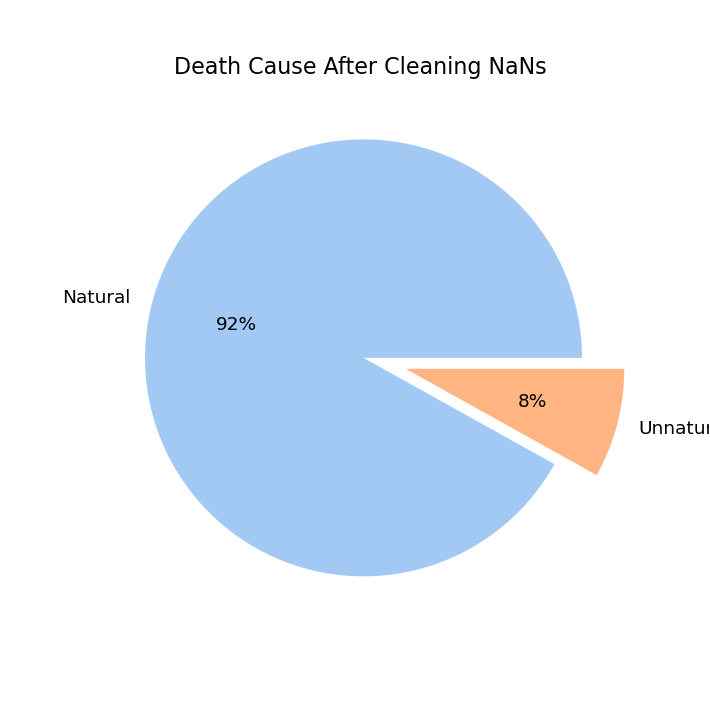

In [75]:
fig, ax = plt.subplots(1,1, figsize = (4,4))

colors = sns.color_palette('pastel')[0:5]
labels = ["Natural", "Unnatural"]
explode = [ 0, .2]

#create pie chart
ax.set_title('Death Cause After Cleaning NaNs ')
ax.pie(df['unnatural'].value_counts(),
       labels = labels, 
       colors = colors, 
       explode = explode, 
       autopct='%.0f%%');

## 5) Choice Of Metric

Our choice of performance metric depends on our targeted end-user: life insurance companies.  To reduce the frequency of sticker shock based on discrepancy between advertised premia and final quotes, it is best for the model to prefer to make false positive errors instead of false negative errors.  However, the model should be penalized for making a large number of false positive errors, which happen when the model classifies the majority of training instances as unnatural deaths.  Therefore, we measure model performance by the macro f1 score.  Our baseline model for comparison was a model which classified an instance as an unnatural death with probability equal to the training proportion of unnatural deaths.  

##  6) MODEL SELECTION

### 6.1) General Selection with Kfold Cross Validation

Our base models are as follows:
1. Guess unnatural death with training unnatural death proportion, i.e. unnatural death is a Bernoulli random variable with parameter $p \approx 0.08$.
2. Guess all instances as the majority class, i.e. as natural deaths.
3. Use a default `LogisticRegression`.

We compared the following models against our base models:
1. A `LogisticRegression` with scaled continuous inputs and penalizing observations based on their value of `unnatural`: this is by using the parameter `class_weights = 'balanced'`.
2. `LogisticRegression` with class weights and no scaling.
3. Base `RandomForestClassifier`
4. `RandomForestClassifier` with balanced class weights as in (1).
5. Base Naive Bayes Classifier assuming normal distribution of the features.
6. `XGBoost` with 10 weak learners each of maxiumu depth 8, with class weighting of 700.

In [77]:
df_train, df_test = train_test_split(df.copy(),
                                     shuffle=True,
                                     random_state=123,
                                     test_size=.1,
                                     stratify=df['unnatural'].values)

In [78]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

Scaler = ColumnTransformer([("scaler", StandardScaler(), ['detail_age','education'])], remainder='passthrough')

In [79]:
baseline_models = {
    "Random_Guessing" : DummyClassifier(strategy="stratified") ,
    "Guess_Everything_Natural" : DummyClassifier(strategy="most_frequent"),
    "Logistic_Regression": LogisticRegression()
} 

In [80]:
models = {
    "Logistic_Regression_w_Scaling+Weights" : make_pipeline(Scaler,LogisticRegression(class_weight = 'balanced', penalty="l2")),
    "Logistic_Regression_w_Weights" : LogisticRegression(class_weight = 'balanced'),
    "Random_Forest_Classifier" : RandomForestClassifier(n_estimators=100,max_depth=8),
    "Random_Forest_Classifier_w_Weights" : RandomForestClassifier(n_estimators=100,max_depth=8,class_weight = 'balanced'),
    "Gaussian_Bayes" : GaussianNB(),
    "XGboost" : xgboost.XGBClassifier(n_estimators = 10,
                                      max_depth = 8, 
                                      scale_pos_weight = 700,
                                      random_state = 123)
}

In [81]:
models.update(baseline_models)

In [ ]:
## Make a KFold object
n_splits = 5
kfold = StratifiedKFold(n_splits= n_splits, 
                random_state=123,
                shuffle=True)

## This arrays will hold the f1-macro and recall score for each model and split
f1s = np.zeros((len(models), n_splits))
rcls=np.zeros((len(models), n_splits))

## sets a split counter
i = 0

## loop through the kfold here
for train_index, test_index in kfold.split(df_train,df_train.unnatural):
    
    ## cv training and holdout set
    df_tt,  df_ho = df_train.iloc[train_index], df_train.iloc[test_index]
    
    ## ROC curve dictionary to display 
    ROC_dict = {}
    
    ##train the models in the split
    for model_index, (model_name, model) in enumerate(models.items()):
        print(model_name, '\n', f'Split: {i}')
        model.fit(df_tt[features], df_tt['unnatural'].values)
        pred = model.predict(df_ho[features])
        pred_proba = model.predict_proba(df_ho[features])[:,1]
        
        f1s[model_index,i] = f1_score(df_ho['unnatural'].values, pred, average = 'macro')
        rcls[model_index, i] = recall_score(df_ho['unnatural'].values, pred)
        
        print(f'{model_name} {i}th validation \n', classification_report(df_ho['unnatural'].values, pred),'\n')
        print('Prediction Percentages : \n', pd.Series(pred).value_counts(normalize=True))
        print('--'*30)
        ROC_dict[model_name] = {}
        ROC_dict[model_name]['fprs'], ROC_dict[model_name]['tprs'], ROC_dict[model_name]['cutoffs'] = roc_curve(df_ho['unnatural'].values,pred_proba)
    
    ##Display the ROC curve
    plt.figure(figsize=(10,8))
    plt.title(f'ROC Curve for split {i}')
    for model_name in ROC_dict.keys():
        plt.plot(ROC_dict[model_name]['fprs'], ROC_dict[model_name]['tprs'], label = f'{model_name}')
    
    plt.plot([0,1],[0,1],'k--', label ='Random Guess Curve')
    plt.xlabel('False Positive Rate', fontsize =16)
    plt.ylabel('True Positive Rate', fontsize =16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=14)

    plt.show()

    i = i + 1

In [ ]:
recalls = pd.DataFrame(rcls,
            index = list(models.keys()),
            columns = [f'recall_{i}' for i in range(n_splits)])
recalls['recall_mean'] = recalls.mean(axis=1)
f1_scores = pd.DataFrame(f1s,
            index = list(models.keys()),
            columns = [f'f1_macro_{i}' for i in range(n_splits)])
f1_scores['f1_mean'] = f1_scores.mean(axis=1)
display(pd.concat([recalls, f1_scores], axis=1))


Based on the output above, it seems that while considering both macro $f_1$ and recall, the model `RandomForestClassifer` with `class_weights = 'balanced'` seems like the model with the most potential.

### 6.2) Hyperparameter Tuning for Best Candidates

In [ ]:
n_estimators = [2,3]
max_depth = [2,6]

param_grid = { 'n_estimators': n_estimators,
          #    'max_features': [ 'sqrt', 'log2'],
              'max_depth' : max_depth,
              'criterion' :['gini', 'entropy']
             }

In [ ]:
grid_cv=GridSearchCV(RandomForestClassifier(class_weight = 'balanced',random_state = 123),#put model here something lifinal_predictionsearRegression()
                     param_grid = param_grid,
                     scoring = 'f1_macro',
                     cv = StratifiedKFold(n_splits=5, random_state=101, shuffle=True),
                     verbose=4)


grid_cv.fit(df_train[features],df_train.unnatural)

In [ ]:
np.array(grid_cv.cv_results_['mean_test_score']).reshape(2,2,2)

In [ ]:
np.array(grid_cv.cv_results_['mean_test_score']).reshape(2,-1)

In [ ]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(2,len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(2,len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

# Calling Method 
plot_grid_search(grid_cv.cv_results_, max_depth, n_estimators, 'max_depth', 'N Estimators')

## 7) Deploying the Final Model

Here, we will deploy the best model, whose hyperparameters were selected using `GridSearchCV`.  Below, we have plotted the resulting confusion matrix.

In [ ]:
final_predictions = grid_cv.best_estimator_.predict(df_test[features])

cm = confusion_matrix(df_test.unnatural.values, final_predictions)

disp_cm = ConfusionMatrixDisplay(cm)

disp_cm.plot()

In [ ]:
score_df = pd.DataFrame({'feature':features,
                            'importance_score': grid_cv.best_estimator_.feature_importances_})

score_df.sort_values('importance_score', ascending=False)

In [ ]:
print(classification_report(df_test.unnatural.values, final_predictions))
print('f1 macro test score :', f1_score(df_test.unnatural.values, final_predictions, average = 'macro'))
print('recall test score :', recall_score(df_test.unnatural.values, final_predictions))

print('Prediction Percentages : \n', pd.Series(final_predictions).value_counts(normalize=True))

# 8) Conclusion

1. Scores
2. Percentage classified as unnatural close to population proportion -- we aren't cheating like with XGBoost
3. Feature importace -- these are the important features for our problem in such and such an order.